In [4]:
def compute_deltaX_true_from_drug(adata, control_name="DMSO_TF"):
    obs = adata.obs.copy()
    
    # 1. Control baseline
    control_mask = obs["drug"] == control_name
    if control_mask.sum() == 0:
        raise ValueError(f"No control cells found for drug={control_name}")
    
    X_control = adata.X[control_mask].toarray()
    X_control_mean = X_control.mean(axis=0)   # baseline
    
    print(f"[INFO] Control samples={control_mask.sum()}, mean shape={X_control_mean.shape}")

    # 2. Drug 목록
    drug_list = [d for d in obs["drug"].unique().tolist() if d != control_name]

    deltaX_list = []
    index_list = []

    for drug_name in drug_list:
        drug_mask = obs["drug"] == drug_name
        X_drug = adata.X[drug_mask].toarray()
        X_drug_mean = X_drug.mean(axis=0)

        deltaX = X_drug_mean - X_control_mean
        deltaX_list.append(deltaX)
        index_list.append(drug_name)
        
        print(f"[INFO] {drug_name}: {drug_mask.sum()} cells")

    genes = adata.var.index.tolist()
    deltaX_df = pd.DataFrame(deltaX_list, index=index_list, columns=genes)

    return deltaX_df, X_control_mean

In [5]:
import scanpy as sc
import pandas as pd

adata = sc.read_h5ad("./hvg_outputs/tahoe_CVCL_0546_DMSO_multi_norm_hvg.h5ad")

deltaX_true_df, X_control_mean = compute_deltaX_true_from_drug(adata, control_name="DMSO_TF")
deltaX_true_df.head()

[INFO] Control samples=108816, mean shape=(2000,)
[INFO] Retinoic acid: 17032 cells
[INFO] Vinblastine (sulfate): 12554 cells
[INFO] Pasireotide (acetate): 15656 cells
[INFO] Riluzole hydrochloride: 18110 cells
[INFO] Isocorydine: 15319 cells
[INFO] Quinestrol: 20707 cells
[INFO] Aliskiren: 17198 cells
[INFO] Larotrectinib: 11004 cells
[INFO] Bergenin: 15613 cells
[INFO] Rimonabant: 16046 cells
[INFO] Lumateperone (tosylate): 17097 cells
[INFO] Hexylresorcinol: 18097 cells
[INFO] Goserelin (acetate): 19789 cells
[INFO] Fusidic acid: 18886 cells
[INFO] Cloxacillin (sodium): 18806 cells
[INFO] Selinexor: 14094 cells
[INFO] Anethole trithione: 19454 cells
[INFO] Clonidine (hydrochloride): 24871 cells
[INFO] Adagrasib: 78280 cells


,ENSG00000001084,ENSG00000005108,ENSG00000005884,ENSG00000007062,ENSG00000007350,ENSG00000008256,ENSG00000008394,ENSG00000009694,ENSG00000009765,ENSG00000011422,...,ENSG00000290898,ENSG00000290915,ENSG00000290935,ENSG00000290938,ENSG00000290980,ENSG00000290996,ENSG00000291065,ENSG00000291163,ENSG00000291187,ENSG00000291233
Retinoic acid,0.045016,0.014907,0.101981,0.002759,-0.000060,0.109190,0.060274,0.003158,0.000051,0.052447,...,0.000102,0.003133,-0.000018,0.000016,0.000096,0.000000,0.002558,-0.000057,0.000097,-0.000039
Vinblastine (sulfate),-0.056783,0.011938,0.173060,-0.002376,-0.000211,0.144952,-0.005427,0.001624,0.000623,0.179332,...,0.000000,0.007741,-0.000018,-0.000061,0.000000,0.000123,0.008348,-0.000057,-0.000027,-0.000039
Pasireotide (acetate),0.037435,0.012844,0.084370,0.003528,-0.000066,0.095087,0.049422,0.007007,-0.000050,0.070844,...,0.000000,0.002707,-0.000018,-0.000061,0.000000,0.000000,0.005354,-0.000057,-0.000027,-0.000039
Riluzole hydrochloride,-0.030224,0.009927,0.133287,0.001901,-0.000126,0.044512,0.031561,-0.002838,-0.000056,0.046875,...,0.000115,0.004319,-0.000018,-0.000061,0.000111,0.000141,0.003635,0.000062,0.000085,-0.000039
Isocorydine,0.019084,0.005991,0.090754,0.007322,-0.000340,0.071351,0.042367,-0.001726,0.000102,0.032107,...,0.000000,0.002444,-0.000018,-0.000061,0.000000,0.000000,0.001859,-0.000057,0.000095,-0.000039


## 2. Drug target 정보 확인

In [6]:
import pandas as pd
import ast

def load_drug_target_dict(path):
    df = pd.read_csv(path)

    drug_to_targets = {}

    for _, row in df.iterrows():
        drug = row["drug"]

        # 문자열 형태의 리스트를 실제 리스트로 변환
        targets_str = row["targets"]
        targets = ast.literal_eval(targets_str)

        # 리스트로 저장
        drug_to_targets[drug] = targets

    return drug_to_targets

In [7]:
path = "./drug_dict/drug_targets_CVCL0546.csv"
drug_to_targets = load_drug_target_dict(path)

drug_to_targets["Adagrasib"]

['KRAS']

In [8]:
import scanpy as sc
import numpy as np
import pandas as pd
import ast

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
h5ad_path = "./hvg_outputs/tahoe_CVCL_0546_DMSO_multi_norm_hvg.h5ad"
adata = sc.read_h5ad(h5ad_path)

# 유전자 이름 리스트
gene_list = list(adata.var_names)
print("gene 개수:", len(gene_list))
print("gene_list[:10]:", gene_list[:10])

gene 개수: 2000
gene_list[:10]: ['ENSG00000001084', 'ENSG00000005108', 'ENSG00000005884', 'ENSG00000007062', 'ENSG00000007350', 'ENSG00000008256', 'ENSG00000008394', 'ENSG00000009694', 'ENSG00000009765', 'ENSG00000011422']


In [10]:
token_to_id = {}
idx = 0

# special tokens
for tok in ["[PAD]", "[CLS]", "[FP]", "[FR]"]:
    token_to_id[tok] = idx
    idx += 1

# baseline gene tokens
for g in gene_list:
    token_to_id[f"GENE_{g}_BASE"] = idx
    idx += 1

# target gene tokens
for g in gene_list:
    token_to_id[f"{g}_TARGET"] = idx
    idx += 1

vocab_size = len(token_to_id)
print("vocab_size:", vocab_size)

vocab_size: 4004


In [11]:
class GeneEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, input_ids):
        return self.embedding(input_ids)


class AttrEmbedding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )

    def forward(self, values):
        # values: (B, L)
        return self.mlp(values.unsqueeze(-1))


class PosEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos = nn.Embedding(max_len, d_model)

    def forward(self, input_ids):
        # input_ids: (B, L) → 길이 L 이용해서 position ID 생성
        B, L = input_ids.shape
        pos_ids = torch.arange(L, device=input_ids.device).unsqueeze(0).expand(B, L)
        return self.pos(pos_ids)


class Cell2SentenceEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=8, num_layers=4, max_len=512):
        super().__init__()

        self.gene_emb = GeneEmbedding(vocab_size, d_model)
        self.attr_emb = AttrEmbedding(d_model)
        self.pos_emb  = PosEmbedding(max_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=1024,
            batch_first=True,
            dropout=0.1,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, input_ids, values, attention_mask):
        """
        input_ids:      (B, L)  token index
        values:         (B, L)  baseline expr or 0
        attention_mask: (B, L)  1=유효, 0=PAD
        """
        e_gene = self.gene_emb(input_ids)
        e_attr = self.attr_emb(values)
        e_pos  = self.pos_emb(input_ids)

        x = e_gene + e_attr + e_pos   # (B, L, d_model)

        key_padding_mask = (attention_mask == 0)  # True=PAD
        out = self.encoder(x, src_key_padding_mask=key_padding_mask)

        h_cls = out[:, 0, :]          # [CLS] 토큰
        return h_cls

In [12]:
class FRHead(nn.Module):
    def __init__(self, d_model, n_genes):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, n_genes)
        )

    def forward(self, h_cls):
        # h_cls: (B, d_model)
        return self.mlp(h_cls)        # (B, n_genes)


class FRModel(nn.Module):
    def __init__(self, encoder, d_model, n_genes):
        super().__init__()
        self.encoder = encoder
        self.head = FRHead(d_model, n_genes)

    def forward(self, input_ids, values, mask):
        h_cls = self.encoder(input_ids, values, mask)
        deltaX_pred = self.head(h_cls)
        return deltaX_pred

In [13]:
TARGETS_CSV = "./drug_dict/drug_targets_CVCL0546.csv"

drug_targets_df = pd.read_csv(TARGETS_CSV)
drug_targets_df["targets"] = drug_targets_df["targets"].apply(ast.literal_eval)

drug_to_targets = dict(zip(drug_targets_df["drug"], drug_targets_df["targets"]))
list(drug_to_targets.items())[:5]

[('Adagrasib', ['KRAS']),
 ('Aliskiren', ['REN']),
 ('Anethole trithione', ['TGM2']),
 ('Clonidine (hydrochloride)',
  ['ADRA1A', 'ADRA1B', 'ADRA1D', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'AOC3']),
 ('Goserelin (acetate)', ['GNRH1', 'GNRHR', 'LHCGR'])]

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

control_drug = "DMSO_TF"

# 1) 전체 drug 목록에서 control은 제외
all_drugs = adata.obs["drug"].unique().tolist()
drug_list = [d for d in all_drugs if d != control_drug]

print("전체 drug 개수:", len(drug_list))
print("예시 drugs:", drug_list[:10])

# 2) drug 단위로 train / temp (valid+test) 먼저 나누기
train_drugs, temp_drugs = train_test_split(
    drug_list,
    test_size=0.3,      # 70% train, 30% (valid+test)
    random_state=42
)

# 3) temp를 다시 valid / test로 나누기
valid_drugs, test_drugs = train_test_split(
    temp_drugs,
    test_size=0.5,      # 15% valid, 15% test
    random_state=42
)

print("Train drugs 개수:", len(train_drugs))
print("Valid drugs 개수:", len(valid_drugs))
print("Test  drugs 개수:", len(test_drugs))

print("Train drugs 예시:", train_drugs[:5])
print("Valid drugs 예시:", valid_drugs[:5])
print("Test  drugs 예시:", test_drugs[:5])

# 4) 이제 각 drug set에 해당하는 cell index 뽑기
train_mask = adata.obs["drug"].isin(train_drugs)
valid_mask = adata.obs["drug"].isin(valid_drugs)
test_mask  = adata.obs["drug"].isin(test_drugs)

train_idx = np.where(train_mask.values)[0]
valid_idx = np.where(valid_mask.values)[0]
test_idx  = np.where(test_mask.values)[0]

print("Train cells:", len(train_idx))
print("Valid cells:", len(valid_idx))
print("Test  cells:", len(test_idx))

전체 drug 개수: 19
예시 drugs: ['Retinoic acid', 'Vinblastine (sulfate)', 'Pasireotide (acetate)', 'Riluzole hydrochloride', 'Isocorydine', 'Quinestrol', 'Aliskiren', 'Larotrectinib', 'Bergenin', 'Rimonabant']
Train drugs 개수: 13
Valid drugs 개수: 3
Test  drugs 개수: 3
Train drugs 예시: ['Riluzole hydrochloride', 'Fusidic acid', 'Selinexor', 'Clonidine (hydrochloride)', 'Pasireotide (acetate)']
Valid drugs 예시: ['Hexylresorcinol', 'Bergenin', 'Vinblastine (sulfate)']
Test  drugs 예시: ['Retinoic acid', 'Quinestrol', 'Anethole trithione']
Train cells: 285156
Valid cells: 46264
Test  cells: 57193


In [15]:
class FRDataset(Dataset):
    """
    f_r 학습용 Dataset:
    - 입력: baseline sentence + target tokens (FR sentence)
    - 라벨: ΔX_true = X_drug_cell - baseline_expr
    """
    def __init__(
        self,
        adata,
        gene_list,
        drug_to_targets,
        token_to_id,
        max_len=512,
        top_k=300,
        control_drug="DMSO_TF",
        sample_indices=None,
    ):
        super().__init__()
        self.adata = adata
        self.gene_list = gene_list
        self.drug_to_targets = drug_to_targets
        self.token_to_id = token_to_id
        self.max_len = max_len
        self.top_k = top_k
        self.control_drug = control_drug

        # 1) baseline_expr 만들기 (control cell 평균)
        control_mask = (adata.obs["drug"] == control_drug)
        assert control_mask.sum() > 0, "DMSO_TF control cell이 없습니다."

        # csr → dense 평균 (1, n_genes) → (n_genes,)
        self.baseline_expr = np.array(
            adata.X[control_mask].mean(axis=0)
        ).ravel()

        # 2) 학습에 쓸 cell index (drug 셀만)
        is_drug = adata.obs["drug"] != control_drug
        has_target = adata.obs["drug"].isin(drug_to_targets.keys())
        base_mask = (is_drug & has_target)

        # base_mask에서 가능한 candidate cell index 모두 뽑기
        all_candidate_indices = np.where(base_mask.values)[0]

        # sample_indices가 None이면 → 전체 candidate 사용
        # sample_indices가 있으면 → 그 중 교집합만 사용
        if sample_indices is None:
            self.sample_indices = all_candidate_indices
        else:
            sample_indices = np.array(sample_indices)
            self.sample_indices = np.intersect1d(all_candidate_indices, sample_indices)

        print("사용할 cell 개수:", len(self.sample_indices))

    def __len__(self):
        return len(self.sample_indices)

    def build_fr_sentence_for_drug(self, drug_name):
        """
        baseline_expr (global) + drug_name 기반으로
        FR sentence (input_ids, values, mask) 1D 텐서 생성
        """
        tokens = []
        values = []

        # special tokens
        tokens.append("[CLS]"); values.append(0.0)
        tokens.append("[FR]");  values.append(0.0)

        # baseline top-K gene 선택
        idx_sorted = np.argsort(-np.abs(self.baseline_expr))[:self.top_k]
        for idx in idx_sorted:
            gene = self.gene_list[idx]
            tok = f"GENE_{gene}_BASE"
            if tok in self.token_to_id:
                tokens.append(tok)
                values.append(float(self.baseline_expr[idx]))

        # drug target gene 토큰 추가
        target_genes = self.drug_to_targets.get(drug_name, [])
        for tg in target_genes:
            tok = f"{tg}_TARGET"
            if tok in self.token_to_id:
                tokens.append(tok)
                values.append(0.0)

        # token → id
        input_ids = [self.token_to_id[t] for t in tokens]
        attention_mask = [1] * len(input_ids)

        # 패딩
        if len(input_ids) < self.max_len:
            pad_len = self.max_len - len(input_ids)
            input_ids += [self.token_to_id["[PAD]"]] * pad_len
            values    += [0.0] * pad_len
            attention_mask += [0] * pad_len
        else:
            input_ids = input_ids[:self.max_len]
            values    = values[:self.max_len]
            attention_mask = attention_mask[:self.max_len]

        input_ids = torch.tensor(input_ids, dtype=torch.long)
        values    = torch.tensor(values,    dtype=torch.float32)
        mask      = torch.tensor(attention_mask, dtype=torch.long)
        return input_ids, values, mask

    def __getitem__(self, idx):
        """
        반환:
        - input_ids: (L,)
        - values:    (L,)
        - mask:      (L,)
        - deltaX_true: (n_genes,)
        """
        cell_idx = self.sample_indices[idx]
        drug_name = self.adata.obs["drug"].iloc[cell_idx]

        # X_drug_cell: 1 x n_genes → (n_genes,)
        x_drug = np.array(self.adata.X[cell_idx].toarray()).ravel()

        # ΔX_true = X_drug_cell - baseline_expr
        deltaX_true = x_drug - self.baseline_expr

        input_ids, values, mask = self.build_fr_sentence_for_drug(drug_name)

        return (
            input_ids,
            values,
            mask,
            torch.tensor(deltaX_true, dtype=torch.float32),
        )

In [16]:
train_dataset = FRDataset(
    adata=adata,
    gene_list=gene_list,
    drug_to_targets=drug_to_targets,
    token_to_id=token_to_id,
    max_len=512,
    top_k=300,
    control_drug="DMSO_TF",
    sample_indices=train_idx,     
)

valid_dataset = FRDataset(
    adata=adata,
    gene_list=gene_list,
    drug_to_targets=drug_to_targets,
    token_to_id=token_to_id,
    max_len=512,
    top_k=300,
    control_drug="DMSO_TF",
    sample_indices=valid_idx,      
)

test_dataset = FRDataset(
    adata=adata,
    gene_list=gene_list,
    drug_to_targets=drug_to_targets,
    token_to_id=token_to_id,
    max_len=512,
    top_k=300,
    control_drug="DMSO_TF",
    sample_indices=test_idx,     
)

from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


사용할 cell 개수: 214035
사용할 cell 개수: 30651
사용할 cell 개수: 57193


In [17]:
d_model = 256
n_genes = len(gene_list)

encoder = Cell2SentenceEncoder(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=8,
    num_layers=4,
    max_len=512,
).to(device)

fr_model = FRModel(
    encoder=encoder,
    d_model=d_model,
    n_genes=n_genes,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(fr_model.parameters(), lr=1e-4)

In [18]:
from tqdm import tqdm

n_epochs = 5   # 테스트용
fr_model.train()

for epoch in range(1, n_epochs + 1):
    epoch_loss = 0.0

    # tqdm progress bar (epoch별)
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=True)

    for batch in pbar:
        input_ids, values, mask, deltaX_true = batch

        input_ids = input_ids.to(device)
        values    = values.to(device)
        mask      = mask.to(device)
        deltaX_true = deltaX_true.to(device)

        optimizer.zero_grad()

        deltaX_pred = fr_model(input_ids, values, mask)

        loss = criterion(deltaX_pred, deltaX_true)
        loss.backward()
        optimizer.step()

        # accumulate
        epoch_loss += loss.item() * input_ids.size(0)

        # tqdm bar에 현재 batch loss 표시
        pbar.set_postfix({"batch_loss": loss.item()})

    avg_loss = epoch_loss / len(train_dataset)
    print(f"[Epoch {epoch}] f_r MSE loss: {avg_loss:.6f}")

Epoch 1: 100%|██████████| 6689/6689 [10:43<00:00, 10.39it/s, batch_loss=0.129]


[Epoch 1] f_r MSE loss: 0.127689


Epoch 2: 100%|██████████| 6689/6689 [10:42<00:00, 10.41it/s, batch_loss=0.129]


[Epoch 2] f_r MSE loss: 0.127608


Epoch 3: 100%|██████████| 6689/6689 [10:43<00:00, 10.39it/s, batch_loss=0.136]


[Epoch 3] f_r MSE loss: 0.127605


Epoch 4: 100%|██████████| 6689/6689 [10:45<00:00, 10.36it/s, batch_loss=0.126]


[Epoch 4] f_r MSE loss: 0.127603


Epoch 5: 100%|██████████| 6689/6689 [10:43<00:00, 10.39it/s, batch_loss=0.124]

[Epoch 5] f_r MSE loss: 0.127602


In [19]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for batch in loader:
            input_ids, values, mask, deltaX_true = batch

            input_ids = input_ids.to(device)
            values    = values.to(device)
            mask      = mask.to(device)
            deltaX_true = deltaX_true.to(device)

            deltaX_pred = model(input_ids, values, mask)
            loss = criterion(deltaX_pred, deltaX_true)

            total_loss += loss.item() * input_ids.size(0)
            count += input_ids.size(0)

    model.train()
    return total_loss / count

In [20]:
from tqdm import tqdm

n_epochs = 5   # 테스트용
fr_model.train()

for epoch in range(1, n_epochs + 1):
    epoch_loss = 0.0

    # tqdm progress bar (epoch별)
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=True)

    for batch in pbar:
        input_ids, values, mask, deltaX_true = batch

        input_ids = input_ids.to(device)
        values    = values.to(device)
        mask      = mask.to(device)
        deltaX_true = deltaX_true.to(device)

        optimizer.zero_grad()

        deltaX_pred = fr_model(input_ids, values, mask)

        loss = criterion(deltaX_pred, deltaX_true)
        loss.backward()
        optimizer.step()

        # accumulate
        epoch_loss += loss.item() * input_ids.size(0)

        # tqdm bar에 현재 batch loss 표시
        pbar.set_postfix({"batch_loss": loss.item()})

    # ====== Epoch 끝난 직후 Train Loss 계산 ======
    avg_loss = epoch_loss / len(train_dataset)
    print(f"[Epoch {epoch}] f_r MSE loss: {avg_loss:.6f}")

    # ====== Validation Loss ======
    valid_loss = evaluate(fr_model, valid_loader)
    print(f"[Epoch {epoch}] valid MSE loss: {valid_loss:.6f}")

Epoch 1: 100%|██████████| 6689/6689 [11:11<00:00,  9.96it/s, batch_loss=0.126]


[Epoch 1] f_r MSE loss: 0.127601


/data/aiffel/miniconda3/envs/babayakga/lib/python3.10/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


[Epoch 1] valid MSE loss: 0.129208


Epoch 2: 100%|██████████| 6689/6689 [07:21<00:00, 15.15it/s, batch_loss=0.127]


[Epoch 2] f_r MSE loss: 0.127601
[Epoch 2] valid MSE loss: 0.129196


Epoch 3: 100%|██████████| 6689/6689 [09:13<00:00, 12.09it/s, batch_loss=0.118]


[Epoch 3] f_r MSE loss: 0.127601
[Epoch 3] valid MSE loss: 0.129187


Epoch 4: 100%|██████████| 6689/6689 [10:42<00:00, 10.42it/s, batch_loss=0.124]


[Epoch 4] f_r MSE loss: 0.127600
[Epoch 4] valid MSE loss: 0.129176


Epoch 5: 100%|██████████| 6689/6689 [10:44<00:00, 10.38it/s, batch_loss=0.135]


[Epoch 5] f_r MSE loss: 0.127601
[Epoch 5] valid MSE loss: 0.129182


In [21]:
import torch
import numpy as np
from scipy.stats import pearsonr
from tqdm import tqdm
import torch.nn.functional as F

def evaluate_metrics(model, loader, device="cuda"):
    model.eval()

    mse_list = []
    mae_list = []
    pearson_list = []
    cosine_list = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids, values, mask, deltaX_true = batch

            input_ids = input_ids.to(device)
            values = values.to(device)
            mask = mask.to(device)
            deltaX_true = deltaX_true.to(device)

            deltaX_pred = model(input_ids, values, mask)

            # --- MSE / MAE ---
            mse = F.mse_loss(deltaX_pred, deltaX_true, reduction='none').mean(dim=1)
            mae = F.l1_loss(deltaX_pred, deltaX_true, reduction='none').mean(dim=1)

            mse_list.extend(mse.cpu().numpy())
            mae_list.extend(mae.cpu().numpy())

            # --- Pearson & Cosine ---
            deltaX_pred_np = deltaX_pred.cpu().numpy()
            deltaX_true_np = deltaX_true.cpu().numpy()

            for p, t in zip(deltaX_pred_np, deltaX_true_np):
                # Pearson
                corr, _ = pearsonr(p, t)
                pearson_list.append(corr)

                # Cosine
                cos = np.dot(p, t) / (np.linalg.norm(p) * np.linalg.norm(t) + 1e-8)
                cosine_list.append(cos)

    return {
        "MSE": np.mean(mse_list),
        "MAE": np.mean(mae_list),
        "Pearson": np.mean(pearson_list),
        "Cosine": np.mean(cosine_list),
    }

In [22]:
test_metrics = evaluate_metrics(fr_model, test_loader, device)
print(test_metrics)

Evaluating: 100%|██████████| 1788/1788 [02:05<00:00, 14.23it/s]

{'MSE': 0.1299423, 'MAE': 0.118383, 'Pearson': 0.07667040101025176, 'Cosine': 0.08057983792426411}


In [23]:
from tqdm import tqdm

train_losses = []
valid_losses = []

n_epochs = 5   # 테스트용
fr_model.train()

for epoch in range(1, n_epochs + 1):
    epoch_loss = 0.0

    # tqdm progress bar (epoch별)
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=True)

    for batch in pbar:
        input_ids, values, mask, deltaX_true = batch

        input_ids = input_ids.to(device)
        values    = values.to(device)
        mask      = mask.to(device)
        deltaX_true = deltaX_true.to(device)

        optimizer.zero_grad()

        deltaX_pred = fr_model(input_ids, values, mask)

        loss = criterion(deltaX_pred, deltaX_true)
        loss.backward()
        optimizer.step()

        # accumulate
        epoch_loss += loss.item() * input_ids.size(0)

        # tqdm bar에 현재 batch loss 표시
        pbar.set_postfix({"batch_loss": loss.item()})

    # ====== Epoch 끝난 직후 Train Loss 계산 ======
    avg_loss = epoch_loss / len(train_dataset)
    print(f"[Epoch {epoch}] f_r MSE loss: {avg_loss:.6f}")

    # ====== Validation Loss ======
    valid_loss = evaluate(fr_model, valid_loader)
    print(f"[Epoch {epoch}] valid MSE loss: {valid_loss:.6f}")

    avg_loss = epoch_loss / len(train_dataset)
    train_losses.append(avg_loss)

    valid_loss = evaluate(fr_model, valid_loader)
    valid_losses.append(valid_loss)

    print(f"[Epoch {epoch}] train={avg_loss:.6f}, valid={valid_loss:.6f}")

Epoch 1: 100%|██████████| 6689/6689 [10:46<00:00, 10.35it/s, batch_loss=0.12] 


[Epoch 1] f_r MSE loss: 0.127600
[Epoch 1] valid MSE loss: 0.129189
[Epoch 1] train=0.127600, valid=0.129189


Epoch 2: 100%|██████████| 6689/6689 [08:42<00:00, 12.80it/s, batch_loss=0.131]


[Epoch 2] f_r MSE loss: 0.127600
[Epoch 2] valid MSE loss: 0.129193
[Epoch 2] train=0.127600, valid=0.129193


Epoch 3: 100%|██████████| 6689/6689 [07:37<00:00, 14.63it/s, batch_loss=0.132]


[Epoch 3] f_r MSE loss: 0.127600
[Epoch 3] valid MSE loss: 0.129183
[Epoch 3] train=0.127600, valid=0.129183


Epoch 4: 100%|██████████| 6689/6689 [07:18<00:00, 15.25it/s, batch_loss=0.131]


[Epoch 4] f_r MSE loss: 0.127600
[Epoch 4] valid MSE loss: 0.129195
[Epoch 4] train=0.127600, valid=0.129195


Epoch 5: 100%|██████████| 6689/6689 [07:15<00:00, 15.36it/s, batch_loss=0.127]


[Epoch 5] f_r MSE loss: 0.127600
[Epoch 5] valid MSE loss: 0.129193
[Epoch 5] train=0.127600, valid=0.129193


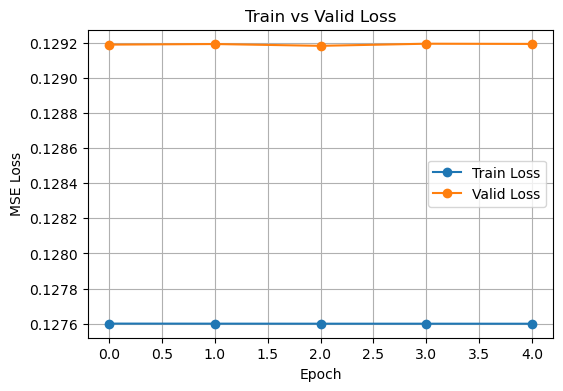

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_losses, marker='o', label="Train Loss")
plt.plot(valid_losses, marker='o', label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Valid Loss")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
def evaluate_per_gene(model, loader, device="cuda"):
    model.eval()

    diffs = []

    with torch.no_grad():
        for batch in loader:
            input_ids, values, mask, deltaX_true = batch
            input_ids = input_ids.to(device)
            values = values.to(device)
            mask = mask.to(device)
            deltaX_true = deltaX_true.to(device)

            pred = model(input_ids, values, mask)
            diff = (pred - deltaX_true).cpu().numpy()
            diffs.append(diff)

    diffs = np.concatenate(diffs, axis=0)    # (N, 5000)
    mse_per_gene = np.mean(diffs**2, axis=0)

    return mse_per_gene

In [26]:
mse_genes = evaluate_per_gene(fr_model, test_loader, device)

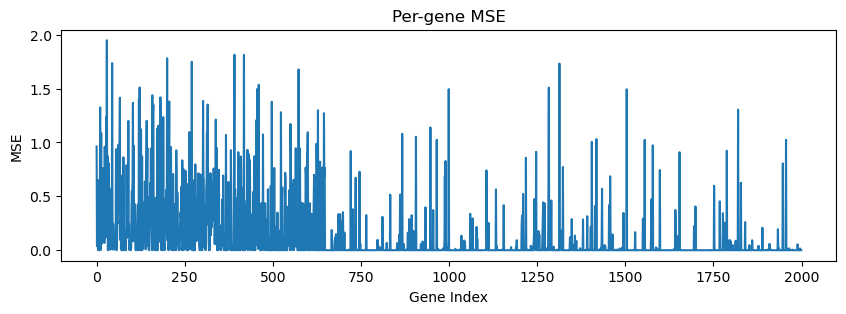

In [27]:
plt.figure(figsize=(10,3))
plt.plot(mse_genes)
plt.title("Per-gene MSE")
plt.xlabel("Gene Index")
plt.ylabel("MSE")
plt.show()